# Определение стоимости автомобилей

***Цель исследования:*** Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости автомобилей на основе требований заказчика.

*Заказчику важны:*

- качество предсказания;
- скорость предсказания;
- время обучения.

***Описание данных:*** Данные о технических характеристиках, комплектации и ценах других автомобилей находятся в файле `/datasets/autos.csv`

*Описание признаков:*

- `DateCrawled` — дата скачивания анкеты из базы;
- `VehicleType` — тип автомобильного кузова;
- `RegistrationYear` — год регистрации автомобиля;
- `Gearbox` — тип коробки передач;
- `Power` — мощность (л. с.);
- `Model` — модель автомобиля;
- `Kilometer` — пробег (км);
- `RegistrationMonth` — месяц регистрации автомобиля;
- `FuelType` — тип топлива;
- `Brand` — марка автомобиля;
- `Repaired` — была машина в ремонте или нет;
- `DateCreated` — дата создания анкеты;
- `NumberOfPictures` — количество фотографий автомобиля;
- `PostalCode` — почтовый индекс владельца анкеты (пользователя);
- `LastSeen` — дата последней активности пользователя;
- `Price` — цена (евро) - целевой признак.

***Ход исследования:*** Планируется 4 этапа:
- Подготовка данных: загрузка и изучение данных;
- Обучение моделей, включая подготовку выборок;
- Анализ моделей: время обучения, время предсказания и качество моделей;
- Общий вывод.

In [113]:
!pip install -U scikit-learn
!pip install matplotlib==3.7.0 -q

In [114]:
# Импортируем необходимые библиотеки и методы.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error

## Подготовка данных

### Загрузка данных

In [115]:
# Откроем и изучим датафрейм.
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [117]:
df.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


**Промежуточный вывод:** Видим данные о технических характеристиках, комплектации и ценах автомобилей. Данные соответствуют описанию задачи с правильными типами данных, за исключением дат. Обзор данных методом info() выявил пропуски.

### Предобработка данных

In [118]:
# Проверим датафрейм на явные дубликаты.
df.duplicated().sum()

4

In [119]:
# Так как дубликатов немного, удалим их.
df = df.drop_duplicates()

In [120]:
# Переведем столбцы в змеиный регистр.
df = df.rename(columns={'DateCrawled':'date_crawled',
                        'Price':'price',
                        'VehicleType':'vehicle_type',
                        'RegistrationYear':'registration_year',
                        'Gearbox':'gearbox',
                        'Power':'power',
                        'Model':'model',
                        'Kilometer':'kilometer',
                        'RegistrationMonth':'registration_month',
                        'FuelType':'fuel_type',
                        'Brand':'brand',
                        'Repaired':'repaired',
                        'DateCreated':'date_created',
                        'NumberOfPictures': 'number_of_pictures',
                        'PostalCode':'postal_code',
                        'LastSeen':'last_seen'})
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [121]:
# Удалим неинформативные признаки.
df = df.drop(['date_crawled','registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [122]:
# Рассмотрим уникальные значения в столбцах датафрейма.
for column in df.columns:
        print('Уникальные значения столбца', column)
        print(df[column].unique())

Уникальные значения столбца price
[  480 18300  9800 ... 12395 18429 10985]
Уникальные значения столбца vehicle_type
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения столбца registration_year
[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500

In [123]:
# Уберем строки датафрейма, где цена ниже 100 евро, как неинформативные.
df = df.loc[df['price'] >= 100]

In [124]:
# Так как скачанные данные датированы 2016 годом, уберем строки с годом регистрации больше.
# Также уберем авто с датой регистрации до 1950 года.
df = df.query('1949 < registration_year < 2017')

In [125]:
# Судя по типам кузова, мощность не может превышать 500 л.с. и не должна быть ниже нуля. Уберем соответствующие строки.
df = df.query('0 < power < 500')

In [126]:
# Исправим неявный дубликат в model.
df['model'] = df['model'].replace(['rangerover'], 'range_rover')

In [127]:
# Переименуем gasoline в petrol, поскольку оба означают одно и то же.
df['fuel_type'] = df['fuel_type'].replace(['gasoline'], 'petrol')

In [128]:
# Пропуски в типе коробки передач заменим большим из двух значением.
df['gearbox'].value_counts()

manual    231257
auto       58726
Name: gearbox, dtype: int64

In [129]:
df['gearbox'] = df['gearbox'].replace(np.nan, 'manual')

In [130]:
# Остальные пропуски оставим.
df.fillna('unknown', inplace=True)

**Промежуточный вывод:** Отобрали информативные признаки, убрали дубликаты и пропуски.

### Статистический анализ данных

In [131]:
# Построим гистограмму распределения цены автомобилей.
df['price'].describe()

count    295244.000000
mean       4870.626140
std        4607.424298
min         100.000000
25%        1350.000000
50%        3200.000000
75%        6999.000000
max       20000.000000
Name: price, dtype: float64

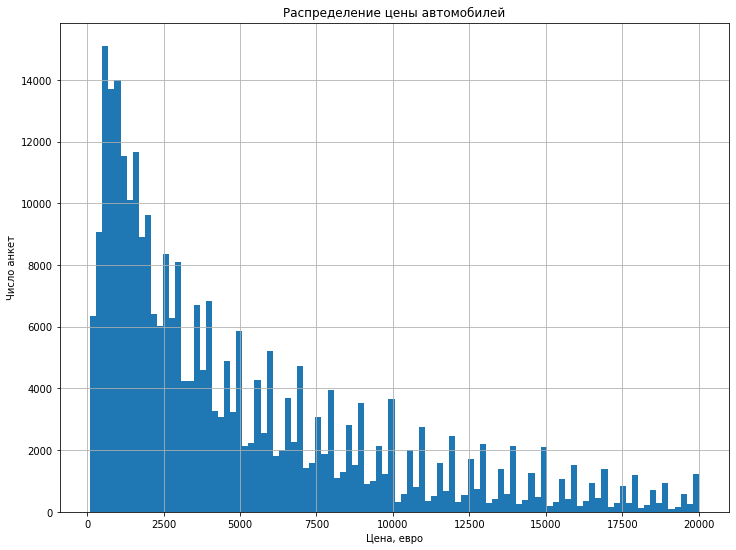

In [132]:
df['price'].hist(bins=100, figsize=(12,9))
plt.title('Распределение цены автомобилей')
plt.xlabel('Цена, евро')
plt.ylabel('Число анкет')
plt.show()

**Описание данных:** Видим распределение цен авто. Так как на продаже могут быть раритетные или особенные модели, большие цены не вызывают подозрений.

In [133]:
# Построим гистограмму распределения года регистрации автомобилей.
df['registration_year'].describe()

count    295244.000000
mean       2002.841368
std           6.489014
min        1950.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

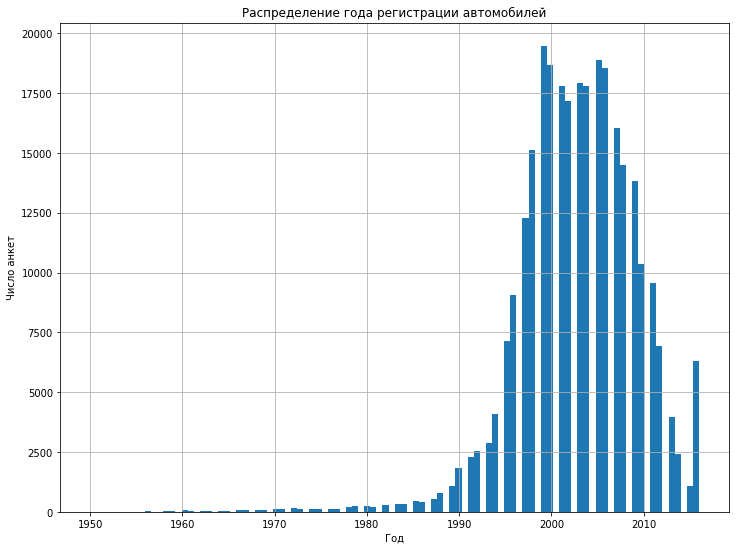

In [134]:
df['registration_year'].hist(bins=100, figsize=(12,9))
plt.title('Распределение года регистрации автомобилей')
plt.xlabel('Год')
plt.ylabel('Число анкет')
plt.show()

**Описание данных:** Видим год регистрации авто. Так как машины могут перепродавать, выброс в 2016 году (году сбора данных) не вызывает подозрений.

In [135]:
# Построим гистограмму распределения мощности автомобилей.
df['power'].describe()

count    295244.000000
mean        120.520133
std          53.377456
min           1.000000
25%          75.000000
50%         111.000000
75%         150.000000
max         490.000000
Name: power, dtype: float64

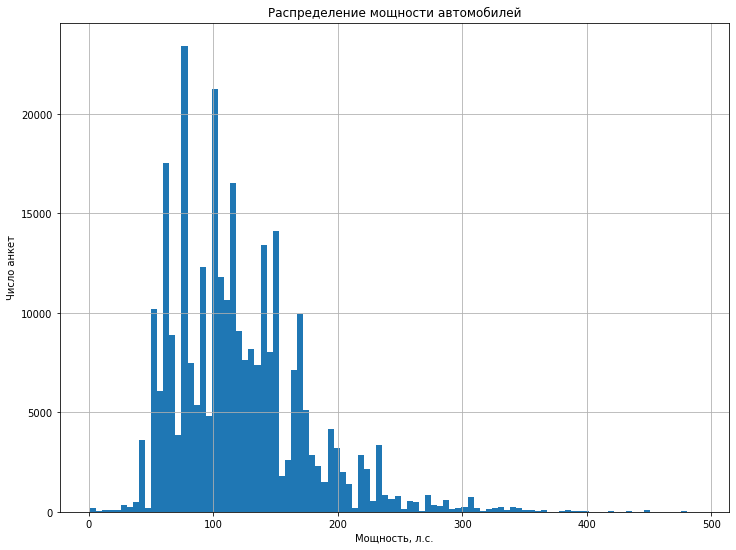

In [136]:
df['power'].hist(bins=100, figsize=(12,9))
plt.title('Распределение мощности автомобилей')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Число анкет')
plt.show()

**Описание данных:** Видим мощность авто. Данных с мощностью ниже 50 л.с. мало, да и такие автомобили, как правило, редкость, если и существуют. Уберем лишние данные.

In [137]:
df = df.loc[df['power'] >= 50]

In [138]:
# Еще раз проверим датафрейм на явные дубликаты после обработки.
df.duplicated().sum()

39531

In [139]:
# Удалим дубликаты.
df = df.drop_duplicates()

In [140]:
# Восстановим индексы для оставшихся данных.
df = df.reset_index(drop=True)

**Промежуточный вывод:** В ходе статистического анализа проверили распределения количественных признаков датафрейма, убрали лишние данные.

## Обучение моделей

Согласно условию задания, подберем модели машинного обучения, оценим их время обучения и качество метрикой RMSE. Значение метрики RMSE должно быть меньше 2500.

### Подготовка выборок и признаков

In [142]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
# Разделим данные на обучающую и тестовую выборки.
X = df.drop(['price'], axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [143]:
# Уточним, какие признаки категоральные, а какие - количественные.
cat_col_names = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
num_col_names = ['registration_year', 'power', 'kilometer']

# Масштабируем количественные признаки с помощью стандартизации.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

# Закодируем категоральные признаки.
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])

encoder_col_names = encoder.get_feature_names_out()

# Cоздадим тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных.
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

# Объединим все преобразованные данные в тренировочный и тестовый датафреймы.
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [144]:
# Зададим метрику RMSE функцией.
def RMSE(target, predictions):
    MSE = mean_squared_error(target, predictions)
    return MSE ** 0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

### LinearRegression

In [154]:
%%time

# Инициализируем модель линейной регрессии.
model_lr = LinearRegression()

# Воспользуемся GridSearchCV для кросс-валидации модели.
param_lr = {}
grid_lr = GridSearchCV(model_lr, param_lr, scoring = RMSE_score, cv=3, verbose=3)
grid_lr.fit(X_train, y_train)

print(grid_lr.best_score_)
print(grid_lr.cv_results_['mean_fit_time'][grid_lr.best_index_])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ..............................., score=-2626.888 total time=   8.2s
[CV 2/3] END ..............................., score=-2636.729 total time=   8.4s
[CV 3/3] END ..............................., score=-2629.865 total time=   8.3s
-2631.160718756368
8.16663153966268
CPU times: user 28.1 s, sys: 8.59 s, total: 36.7 s
Wall time: 36.6 s


**Промежуточный вывод:** Время обучения модели линейной регрессии: 8 сек. RMSE = 2631, что превышает заданное значение.

### DecisionTreeRegressor

In [155]:
%%time

# Инициализируем модель древа решений.
model_dt = DecisionTreeRegressor(random_state=RANDOM_STATE)

# Зададим параметры и воспользуемся GridSearchCV для определения лучших по метрике.
param_dt = {'max_depth':range (1, 20)}
grid_dt = GridSearchCV(model_dt, param_dt, scoring = RMSE_score, cv=3, verbose=3)
grid_dt.fit(X_train, y_train)

print(grid_dt.best_params_)
print(grid_dt.best_score_)
print(grid_dt.cv_results_['mean_fit_time'][grid_dt.best_index_])

Fitting 3 folds for each of 19 candidates, totalling 57 fits
[CV 1/3] END ...................max_depth=1;, score=-3713.012 total time=   0.4s
[CV 2/3] END ...................max_depth=1;, score=-3734.589 total time=   0.4s
[CV 3/3] END ...................max_depth=1;, score=-3728.435 total time=   0.4s
[CV 1/3] END ...................max_depth=2;, score=-3243.581 total time=   0.6s
[CV 2/3] END ...................max_depth=2;, score=-3254.707 total time=   0.6s
[CV 3/3] END ...................max_depth=2;, score=-3255.330 total time=   0.6s
[CV 1/3] END ...................max_depth=3;, score=-2974.771 total time=   0.7s
[CV 2/3] END ...................max_depth=3;, score=-2995.245 total time=   0.7s
[CV 3/3] END ...................max_depth=3;, score=-2979.910 total time=   0.7s
[CV 1/3] END ...................max_depth=4;, score=-2638.438 total time=   0.9s
[CV 2/3] END ...................max_depth=4;, score=-2656.324 total time=   0.9s
[CV 3/3] END ...................max_depth=4;, sc

**Промежуточный вывод:** Время обучения лучшей модели древа решений: 2 сек. Лучший параметр глубины: 15. RMSE = 1924, что удовлетворяет заданному условию.

### LightGBM

In [156]:
# Разделим данные на обучающую и тестовую выборки заново для LightGBM.
features = df.drop('price', axis=1)
target = df['price']

# Переведем категориальные признаки в тип category, который требуется для LightGBM.
for c in features.columns:
  col_type = features[c].dtype
  if col_type == 'object':
    features[c] = features[c].astype('category')

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [158]:
%%time

# Инициализируем модель LightGBM.
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

# Зададим параметры и воспользуемся GridSearchCV для определения лучших по метрике.
param_lgbm = {
    'n_estimators': [100, 200],
    'num_leaves': [20, 30]}
grid_lgbm = GridSearchCV(model_lgbm, param_lgbm, scoring = RMSE_score, n_jobs=-1, cv=3, verbose=3)
grid_lgbm.fit(features_train, target_train)

print(grid_lgbm.best_params_)
print(grid_lgbm.best_score_)
print(grid_lgbm.cv_results_['mean_fit_time'][grid_lgbm.best_index_])

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END n_estimators=100, num_leaves=20;, score=-1655.187 total time=   4.1s
[CV 2/3] END n_estimators=100, num_leaves=20;, score=-1663.450 total time=   3.8s
[CV 3/3] END n_estimators=100, num_leaves=20;, score=-1660.128 total time=   3.2s
[CV 1/3] END n_estimators=100, num_leaves=30;, score=-1630.804 total time=   3.8s
[CV 2/3] END n_estimators=100, num_leaves=30;, score=-1642.963 total time=   4.0s
[CV 3/3] END n_estimators=100, num_leaves=30;, score=-1642.209 total time=   4.4s
[CV 1/3] END n_estimators=200, num_leaves=20;, score=-1622.002 total time=   5.4s
[CV 2/3] END n_estimators=200, num_leaves=20;, score=-1630.099 total time=   5.5s
[CV 3/3] END n_estimators=200, num_leaves=20;, score=-1628.426 total time=   5.3s
[CV 1/3] END n_estimators=200, num_leaves=30;, score=-1604.791 total time=   6.2s
[CV 2/3] END n_estimators=200, num_leaves=30;, score=-1615.614 total time=   7.9s
[CV 3/3] END n_estimators=200, num_lea

**Промежуточный вывод:** Время обучения лучшей модели LightGBM: 7 сек. Лучший параметр числа эстиматоров: 200, число "листьев": 30. RMSE = 1612, что удовлетворяет заданному условию.

## Анализ моделей

Исходя из оценки времени обучения моделей и метрик, остановимся на ***LightGBM***, как лучшей по RMSE. Она обучается немногим дольше древа решений, но зато точнее. Проверим её качество и время предсказания на тестовой выборке.

In [160]:
%%time

# Инициализируем модель LightGBM.
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)

# Зададим параметры и воспользуемся GridSearchCV.
param_lgbm = {
    'n_estimators': [200],
    'num_leaves': [30]}
grid_lgbm = GridSearchCV(model_lgbm, param_lgbm, scoring = RMSE_score, n_jobs=-1, cv=3, verbose=3)
grid_lgbm.fit(features_test, target_test)

print(grid_lgbm.best_score_)
print(grid_lgbm.cv_results_['mean_score_time'][grid_lgbm.best_index_])

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END n_estimators=200, num_leaves=30;, score=-1659.200 total time=   3.4s
[CV 2/3] END n_estimators=200, num_leaves=30;, score=-1691.365 total time=   3.7s
[CV 3/3] END n_estimators=200, num_leaves=30;, score=-1667.750 total time=   3.6s
-1672.7713886568438
0.4380403359731038
CPU times: user 14.4 s, sys: 0 ns, total: 14.4 s
Wall time: 14.3 s


**Промежуточный вывод:** Время предсказания лучшей модели LightGBM: 0.4 сек. RMSE = 1673.

## Общий вывод

**Цель исследования:** Построили модели машинного обучения для определения стоимости автомобилей. Оценили их по критериям, указанным заказчиком.

**Подготовка данных:** Проверили данные на дубликаты, неявные повторы и пропуски, обработали их. Привели данные к одному правильному виду и отобрали только информативные признаки в неамомальных границах.

**Обучение моделей:** Обучили 3 модели машинного обучения, подобрав гиперпараметры, оценили время обучения лучших моделей по оценке метрики RMSE, которая по указаниям заказчика должна быть меньше 2500:
- LinearRegression: Время обучения модели: 8 сек. RMSE = 2631, что превышает заданное значение.
- DecisionTreeRegressor: Время обучения лучшей модели: 2 сек. Лучший параметр глубины: 15. RMSE = 1924, что удовлетворяет заданному условию.
- LightGBM: Время обучения лучшей модели: 7 сек. Лучший параметр числа эстиматоров: 200, число "листьев": 30. RMSE = 1612, что удовлетворяет заданному условию.

**Анализ моделей:** Исходя из оценки времени обучения моделей и метрики RMSE, остановились на ***LightGBM***, как лучшей по RMSE. Она обучается немногим дольше древа решений, но зато точнее. Проверили её качество и время предсказания на тестовой выборке: время предсказания лучшей модели: 0.4 сек. RMSE = 1673.

**Рекомендации:** Вместо количества фотографий разумно было бы ввести оценку внешнего вида автомобиля, если возможно.